### Unit Test 

In [706]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
assumptions = pd.read_csv('assumptions.csv')
parameters = pd.read_csv('parameters.csv')
scenarios = pd.read_csv('scenarios.csv')
policies = pd.read_csv('policies.csv')
mortality = pd.read_csv('mortality.csv')

In [707]:
import math
from scipy.stats import norm

def black_scholes_dividend(option_type, S, K, T, r, sigma, q):
    
    d1 = (math.log((S +0.000001)/ (K+0.000001)) + (r - q + (sigma**2) / 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == 'call':
        option_price = S * math.exp(-q * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return option_price

In [734]:
# assumption scenario paramater policy ids are 2 2 1 8 respectively 

initial_premium = policies.iloc[8-1]['initial_premium']
issue_age = policies.iloc[8-1]['issue_age']
fee_pct_av = policies.iloc[8-1]['fee_pct_av']
benefit_type = policies.iloc[8-1]['benefit_type']
guarantee_rate = policies.iloc[8-1]['guarantee_wd_rate']

r = scenarios.iloc[2-1]['risk_free_rate']
q = scenarios.iloc[2-1]['dividend_yield']
vol = scenarios.iloc[2-1]['volatility']

dur = parameters.iloc[1-1]['proj_periods']
num_paths = parameters.iloc[1-1]['num_paths']

mortality_multiplier = assumptions.iloc[2-1]['mortality_multiplier']
min_wd_delay = assumptions.iloc[2-1]['min_wd_delay']
wd_age = assumptions.iloc[2-1]['wd_age']

qx = mortality['qx']

dur_v = np.arange(0,dur+1,1)
age_v = issue_age + dur_v
prob_surv = np.zeros(len(dur_v))
prob_surv[0] = 1
for t in range(1, len(dur_v)):
    if age_v[t] >= 115:
        prob_surv[t] = 0
    else:
        prob_surv[t] = prob_surv[t-1] * (1 - qx[age_v[t]] * mortality_multiplier)
discount_v = np.exp(-r*dur_v)

### modified version for unit testing 

Basically, I compute put price using BS European Put Analytical Solution with 1 year maturity for every year (k= wd amt, S=av after wd) and discount them to present value and "Sum all the discounted put prices" (without considering mortality)

i.e., I'm applying the BS Analytical Solution dynamically in my loops. 

In [740]:
np.random.seed(0)
GMWB_prices = []
European_put_price = []
for i in range(1,num_paths):
    benefit_base = np.zeros(dur+1)
    av_end_of_period = np.zeros(dur+1)
    remaining_principal = np.zeros(dur+1)
    av_beg_of_period = np.zeros(dur+1)
    fee = np.zeros(dur+1)
    av_after_fee = np.zeros(dur+1)
    av_after_return = np.zeros(dur+1)
    av_after_wd = np.zeros(dur+1)
    wd_claim = np.zeros(dur+1)
    av_end_of_period[0] = initial_premium
    benefit_base[:] =initial_premium
    remaining_principal[0] = initial_premium
    epsilon = np.random.normal(size=dur+1)
    found_negative = False
    put_price = []

    for j in range(1, dur+1):
        av_beg_of_period[j] = av_end_of_period[j-1]
        fee[j] = av_beg_of_period[j] * fee_pct_av
        av_after_fee[j] = av_beg_of_period[j] - fee[j]
        av_after_return[j] = av_after_fee[j] * np.exp((r-q-0.5*(vol**2))*1+vol*epsilon[j]*np.sqrt(1))
        wd_amt = 0
        
        if (age_v[j]>wd_age) and (dur_v[j] > min_wd_delay):
            if benefit_type == 'FOR_LIFE':
                wd_amt = benefit_base[j] * guarantee_rate
            elif benefit_type == 'PRINCIPAL_BACK':
                wd_amt = min(benefit_base[j] * guarantee_rate, max(remaining_principal[j-1],av_after_return[j]))
        remaining_principal[j] = remaining_principal[j-1] - wd_amt
        av_after_wd[j] = av_after_return[j] - wd_amt
        
        if av_after_wd[j] < 0:
            av_after_wd[j] = 0

        if av_after_wd[j] <= 0 and not found_negative: # account for first time account depleted 
            av_after_wd[j] = abs(av_after_return[j] - wd_amt)
            found_negative = True
            wd_claim[j] = max(wd_amt - av_after_wd[j],0)
            av_after_wd[j] = 0
           
            # Changes are made here 
            
            put_price.append(black_scholes_dividend('put',av_after_wd[j],wd_amt,1,0.05,0.3,0.01)*np.exp(-0.05*j))
            continue 
        
        wd_claim[j] = max(wd_amt - av_after_wd[j],0)
        
        # Changes are made here 
        
        put_price.append(black_scholes_dividend('put',av_after_wd[j],wd_amt,1,0.05,0.3,0.01)*np.exp(-0.05*j))
        
        av_end_of_period[j] = av_after_wd[j]
    
    # Changes are made here (remove mortality)
    
    CF = wd_claim * discount_v
    European_put_price.append(np.sum(put_price))
    GMWB_prices.append(np.sum(CF))

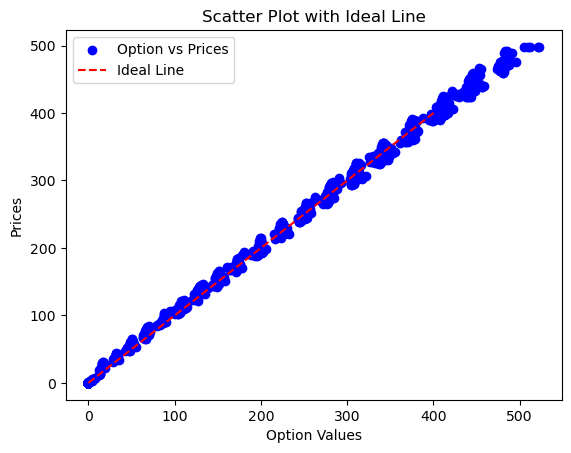

In [743]:
plt.scatter(GMWB_prices, European_put_price, color='b', label='Option vs Prices')
plt.plot([min(option), max(option)], [min(option), max(option)], color='r', linestyle='--', label='Ideal Line')
plt.xlabel('Option Values')
plt.ylabel('Prices')
plt.title('Scatter Plot with Ideal Line')
plt.legend()
plt.show()


In [745]:
np.average(GMWB_prices), np.average(European_put_price)

(179.37353246467038, 180.3346635891532)

###  Conclusion: The value for European put price and GMWB_price (without mortality only) are pretty close. And with morality the price should go down

In [746]:
### With mortality 

np.random.seed(0)
GMWB_prices = []
for i in range(1,num_paths):
    benefit_base = np.zeros(dur+1)
    av_end_of_period = np.zeros(dur+1)
    remaining_principal = np.zeros(dur+1)
    av_beg_of_period = np.zeros(dur+1)
    fee = np.zeros(dur+1)
    av_after_fee = np.zeros(dur+1)
    av_after_return = np.zeros(dur+1)
    av_after_wd = np.zeros(dur+1)
    wd_claim = np.zeros(dur+1)
    av_end_of_period[0] = initial_premium
    benefit_base[:] =initial_premium
    remaining_principal[0] = initial_premium
    epsilon = np.random.normal(size=dur+1)
    found_negative = False
    put_price = []

    for j in range(1, dur+1):
        av_beg_of_period[j] = av_end_of_period[j-1]
        fee[j] = av_beg_of_period[j] * fee_pct_av
        av_after_fee[j] = av_beg_of_period[j] - fee[j]
        av_after_return[j] = av_after_fee[j] * np.exp((r-q-0.5*(vol**2))*1+vol*epsilon[j]*np.sqrt(1))
        wd_amt = 0
        
        if (age_v[j]>wd_age) and (dur_v[j] > min_wd_delay):
            if benefit_type == 'FOR_LIFE':
                wd_amt = benefit_base[j] * guarantee_rate
            elif benefit_type == 'PRINCIPAL_BACK':
                wd_amt = min(benefit_base[j] * guarantee_rate, max(remaining_principal[j-1],av_after_return[j]))
        remaining_principal[j] = remaining_principal[j-1] - wd_amt
        av_after_wd[j] = av_after_return[j] - wd_amt
        
        if av_after_wd[j] < 0:
            av_after_wd[j] = 0

        if av_after_wd[j] <= 0 and not found_negative: # account for first time account depleted 
            av_after_wd[j] = abs(av_after_return[j] - wd_amt)
            found_negative = True
            wd_claim[j] = max(wd_amt - av_after_wd[j],0)
            av_after_wd[j] = 0
            continue
        
        wd_claim[j] = max(wd_amt - av_after_wd[j],0)
                        
        av_end_of_period[j] = av_after_wd[j]
        
    CF = wd_claim * discount_v * prob_surv
    GMWB_prices.append(np.sum(CF))

In [748]:
np.average(GMWB_prices)

116.97413118445616

### Thus, with mortality, prices decrease by about 63

### Try setting Growth Rate to 0 

In [767]:
### Set Growth Rste = 0

np.random.seed(0)
GMWB_prices = []
for i in range(1,num_paths):
    benefit_base = np.zeros(dur+1)
    av_end_of_period = np.zeros(dur+1)
    remaining_principal = np.zeros(dur+1)
    av_beg_of_period = np.zeros(dur+1)
    fee = np.zeros(dur+1)
    av_after_fee = np.zeros(dur+1)
    av_after_return = np.zeros(dur+1)
    av_after_wd = np.zeros(dur+1)
    wd_claim = np.zeros(dur+1)
    av_end_of_period[0] = initial_premium
    benefit_base[:] =initial_premium
    remaining_principal[0] = initial_premium
    epsilon = np.random.normal(size=dur+1)
    found_negative = False
    put_price = []

    for j in range(1, dur+1):
        av_beg_of_period[j] = av_end_of_period[j-1]
        fee[j] = av_beg_of_period[j] * fee_pct_av
        av_after_fee[j] = av_beg_of_period[j] - fee[j]
        av_after_return[j] = av_after_fee[j] * np.exp(0)
        wd_amt = 0
        
        if (age_v[j]>wd_age) and (dur_v[j] > min_wd_delay):
            if benefit_type == 'FOR_LIFE':
                wd_amt = benefit_base[j] * guarantee_rate
            elif benefit_type == 'PRINCIPAL_BACK':
                wd_amt = min(benefit_base[j] * guarantee_rate, max(remaining_principal[j-1],av_after_return[j]))
        remaining_principal[j] = remaining_principal[j-1] - wd_amt
        av_after_wd[j] = av_after_return[j] - wd_amt
        
        if av_after_wd[j] < 0:
            av_after_wd[j] = 0

        if av_after_wd[j] <= 0 and not found_negative: # account for first time account depleted 
            av_after_wd[j] = abs(av_after_return[j] - wd_amt)
            found_negative = True
            wd_claim[j] = max(wd_amt - av_after_wd[j],0)
            av_after_wd[j] = 0
            continue
        
        wd_claim[j] = max(wd_amt - av_after_wd[j],0)
                        
        av_end_of_period[j] = av_after_wd[j]
        
    CF = wd_claim * discount_v * prob_surv
    GMWB_prices.append(np.sum(CF))

In [768]:
np.average(GMWB_prices)

54.927189102749445

In [770]:
fee

array([0.        , 1.        , 0.999     , 0.998001  , 0.997003  ,
       0.996006  , 0.99500999, 0.99401498, 0.99302097, 0.99202794,
       0.99103592, 0.99004488, 0.91905484, 0.84813578, 0.77728764,
       0.70651036, 0.63580385, 0.56516804, 0.49460287, 0.42410827,
       0.35368416, 0.28333048, 0.21304715, 0.1428341 , 0.07269127,
       0.00261858, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [774]:
av_beg_of_period

array([   0.        , 1000.        ,  999.        ,  998.001     ,
        997.002999  ,  996.005996  ,  995.00999   ,  994.01498001,
        993.02096503,  992.02794407,  991.03591613,  990.04488021,
        919.05483533,  848.13578049,  777.28764471,  706.51035707,
        635.80384671,  565.16804287,  494.60287482,  424.10827195,
        353.68416368,  283.33047951,  213.04714903,  142.83410188,
         72.69126778,    2.61857651,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ])

In [775]:
av_after_fee

array([  0.        , 999.        , 998.001     , 997.002999  ,
       996.005996  , 995.00999   , 994.01498001, 993.02096503,
       992.02794407, 991.03591613, 990.04488021, 989.05483533,
       918.13578049, 847.28764471, 776.51035707, 705.80384671,
       635.16804287, 564.60287482, 494.10827195, 423.68416368,
       353.33047951, 283.04714903, 212.83410188, 142.69126778,
        72.61857651,   2.61595794,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ])

### Fees are withdrawn as expected 